(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis and produce all relevant output graphs. If you want to download this notebook and execute it locally on your machine, download this file as a `ipynb` Jupyter notebook file and run it in your local python environment using the download button at the top of this page.

In [1]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, measurements, TimelapseConverter, utils, stress_backend, plotting
import os
import datetime

from skimage import io

from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import yaml

In [2]:
reconstruction_parameters = None
measurement_parameters = None

## Load the data

Replace the following code with the commented out part (and remove the rest) below to load your own data for analysis:

In [3]:
example_data = napari_stress.get_droplet_4d()[0][0]
example_data.shape
filename = None

## Replace this code with a command to import your data. Example:
# filename = 'path/to/data.tif'
# example_data = io.imread(filename)

### Data dimensions
You need to set a few parameters pertaining to your data:

In [4]:
voxel_size_x = 2.078  # microns
voxel_size_y = 2.078  # microns
voxel_size_z = 3.998  # microns
target_voxel_size = 2.078  # microns
time_step = 60  # seconds

### Analysis parameters

In case you ran the reconstruction previously interactively from the napari viewer (as explained [here](toolboxes:droplet_reconstruction:interactive)) and exported the settings, you can import the settings here, too. To do so, simply uncomment the line below (remove the `#`) and provide the path to the saved settings file:

In [5]:
# reconstruction_parameters = utils.import_settings(file_name='path/of/reconstruction/settings.yaml')
# measurement_parameters = utils.import_settings(file_name='path/of/measurement/settings.yaml')

If you used a parameter file, you can skip the next step. Otherwise, use this cell to provide the necessary parameters for the reconstruction and the measurement. The parameters are explained here:
- [Reconstruction](toolboxes:droplet_reconstruction:interactive)
- [Measurement](toolboxes:stress_toolbox:stress_toolbox_interactive)

In [6]:
## Reconstruction settings
smoothing_sigma = 1
n_smoothing_iterations = 10
n_points_first_guess = 256
n_tracing_iterations = 2
resampling_length = 1
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 10
trace_sampling_distance = 0.5
interpolation_method = 'linear' # can be 'linear' 'cubic' or 'nearest'
outlier_tolerance = 1.5
remove_outliers = True

## Measurement settings
max_degree = 20  # spherical harmonics degree
n_quadrature_points = 434  # number of quadrature points to measure on (maximum is 5180)
gamma = 3.3  # interfacial tension of droplet

*Hint:* Not sure whether the code is running probably? To show a progress bar for the processing of each timeframe, set the `verbose` parameter to `True`.  Also, in order to speed up computation, set the `parallelize` parameter to `True`.

In [7]:
verbose = False
parallelize = True

# Analysis

In [8]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


In [9]:
viewer.add_image(example_data)

<Image layer 'example_data' at 0x1a9670a8400>

In [10]:
n_frames = example_data.shape[0]

We put all parameters into a dictionary so we can save and reload them later:

In [11]:
if reconstruction_parameters is None:
    reconstruction_parameters = {
        'voxelsize': np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
        'target_voxelsize': target_voxel_size,
        'smoothing_sigma': smoothing_sigma,
        'n_smoothing_iterations': n_smoothing_iterations,
        'n_points': n_points_first_guess,
        'n_tracing_iterations': n_tracing_iterations,
        'resampling_length': resampling_length,
        'fit_type': fit_type,
        'edge_type': edge_type,
        'trace_length': trace_length,
        'sampling_distance': trace_sampling_distance,
        'interpolation_method':  interpolation_method,
        'outlier_tolerance': outlier_tolerance,
        'remove_outliers': remove_outliers}

if measurement_parameters is None:
    measurement_parameters = {
        'max_degree': max_degree,
        'n_quadrature_points': n_quadrature_points,
        'gamma': gamma,
        'alpha': 0.05}

We run the reconstruction and the stress analysis:

In [12]:
results_reconstruction = reconstruction.reconstruct_droplet(example_data, **reconstruction_parameters,
                                                            verbose=verbose, use_dask=parallelize)

Dask client up and running <Client: 'tcp://127.0.0.1:57180' processes=4 threads=16, memory=31.72 GiB>  Log: http://127.0.0.1:8787/status


c:\Users\johamuel\AppData\Local\mambaforge\envs\stress\lib\site-packages\numpy\core\shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


In [13]:
_ = stress_backend.lbdv_info(Max_SPH_Deg=measurement_parameters['max_degree'],
                             Num_Quad_Pts=measurement_parameters['n_quadrature_points'])

results_stress_analysis = measurements.comprehensive_analysis(results_reconstruction[3][0], **measurement_parameters,
                                                              verbose=verbose, use_dask=parallelize)


Pickling This LBDV data:

generating basis vals
generated basis vals
generating dphi/ dphi_phi vals
done with dphi/ dphi_phi vals


Pickling This LBDV  Chart data:

generating lbdv rotation vals
done with lbdv rotation vals

Dask client already running <Client: 'tcp://127.0.0.1:57180' processes=4 threads=16, memory=31.72 GiB>  Log: http://127.0.0.1:8787/status


In [14]:
for res in results_reconstruction + results_stress_analysis:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)

To get an idea about the returned outputs and which is stored in which layer, let's print them:

In [15]:
for res in results_stress_analysis:
    print('-->', res[1]['name'])
    if 'metadata' in res[1].keys():
        for key in res[1]['metadata'].keys():
            print('\t Metadata: ', key)
    if 'features' in res[1].keys():
        for key in res[1]['features'].keys():
            print('\t Features: ', key)

--> Result of fit spherical harmonics (deg = 20
	 Metadata:  Elipsoid_deviation_contribution_matrix
	 Features:  fit_residue
--> Result of expand points on ellipsoid
	 Features:  fit_residue
--> Result of least squares ellipsoid
--> Result of lebedev quadrature on ellipsoid
	 Metadata:  Tissue_stress_tensor_cartesian
	 Metadata:  Tissue_stress_tensor_elliptical
	 Metadata:  max_issue_stress_anisotropy
	 Features:  mean_curvature
	 Features:  anisotropic_stress_tissue
--> Result of lebedev quadrature (droplet)
	 Metadata:  Gauss_Bonnet_relative_error
	 Metadata:  Gauss_Bonnet_error
	 Metadata:  Gauss_Bonnet_error_radial
	 Metadata:  Gauss_Bonnet_relative_error_radial
	 Metadata:  H0_volume_integral
	 Metadata:  H0_arithmetic
	 Metadata:  H0_surface_integral
	 Metadata:  S2_volume_integral
	 Features:  mean_curvature
	 Features:  difference_mean_curvature_cartesian_radial_manifold
	 Features:  anisotropic_stress_cell
	 Features:  anisotropic_stress
	 Features:  anisotropic_stress_total_r

To make handling further down easier, we store all metadata in a single dataframe if its length corresponds to the number of frames in the data:

In [16]:
_metadata = [layer[1]['metadata'] for layer in results_stress_analysis if 'metadata' in layer[1].keys()]
df_over_time = {}
df_over_time['frame'] = np.arange(n_frames)
for meta in _metadata:
    for key in meta.keys():
        if type(meta[key][0]) == dict:
            for key2 in meta[key][0].keys():
                v = [dic[key2] for dic in meta[key]]
                df_over_time[key2] = v
        else:
            df_over_time[key] = meta[key]
df_over_time = pd.DataFrame(df_over_time)
df_over_time['time'] = df_over_time['frame'] * time_step


# Visualization

In this section, we will plot some interesting results and save the data to disk. The file location will be at the 

In [32]:
mpl.style.use('default')
colormap = 'flare'

In [ ]:
if filename is not None:
    filename_without_ending = os.path.basename(filename).split('.')[0]
    save_directory = os.path.join(os.path.dirname(filename), filename_without_ending + '_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
else: 
    save_directory = os.path.join(os.getcwd(), 'results_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))


In [18]:
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

## Fit errors

We first show all the errors that were calculated during the pointcloud refinement:

In [19]:
fit_error_df = pd.DataFrame(results_reconstruction[3][1]['features'])
fit_error_df

,center,amplitude,slope,background_slope,offset,center_err,amplitude_err,slope_err,background_slope_err,offset_err,distance_to_nearest_neighbor,mean_squared_error,fraction_variance_unexplained,fraction_variance_unexplained_log,idx_of_border
0,10.081819,-0.693914,0.607314,-0.001880,0.676320,0.047377,0.009202,0.008967,0.001105,0.001462,0.957678,0.000006,0.000078,-9.460465,10.081819
1,9.997145,-0.721613,0.618847,-0.001849,0.703815,0.051559,0.012043,0.012329,0.001328,0.002801,1.025464,0.000036,0.000430,-7.751092,9.997145
2,10.019467,-0.705932,0.628523,-0.001733,0.689551,0.049747,0.011424,0.012283,0.001272,0.002654,1.044057,0.000038,0.000473,-7.655380,10.019467
3,10.058297,-0.705460,0.580484,-0.002987,0.678742,0.054540,0.010433,0.009215,0.001236,0.001637,0.939916,0.000007,0.000090,-9.319205,10.058297
4,9.994609,-0.733188,0.628733,-0.001073,0.722375,0.056920,0.014856,0.015583,0.001559,0.004056,1.054863,0.000220,0.002569,-5.964267,9.994609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15926,9.985638,-0.665616,0.638497,-0.000195,0.664523,0.057745,0.013784,0.016346,0.001452,0.003766,1.047671,0.000215,0.002983,-5.814902,9.985638
15927,10.034801,-0.688489,0.639655,0.000048,0.689812,0.065848,0.016203,0.018504,0.001720,0.004350,0.989689,0.000309,0.004026,-5.515095,10.034801
15928,9.993327,-0.637167,0.652894,-0.000147,0.635390,0.070049,0.014840,0.018929,0.001665,0.003482,1.074969,0.000087,0.001272,-6.667318,9.993327
15929,9.962992,-0.677188,0.639055,0.000683,0.684309,0.064850,0.015825,0.018429,0.001657,0.004324,1.025626,0.000293,0.003885,-5.550508,9.962992


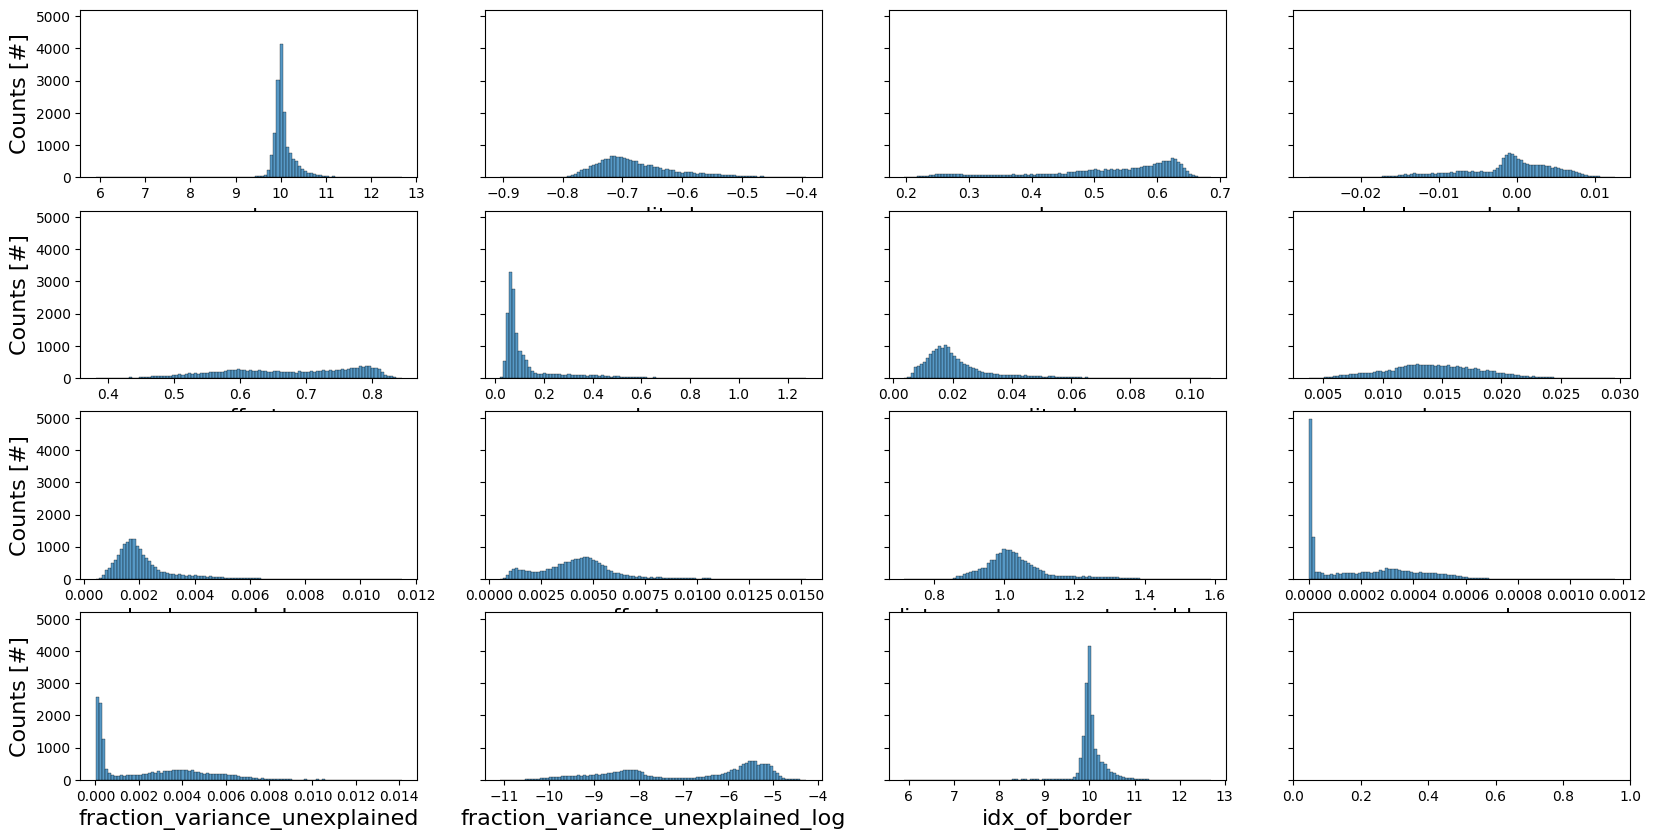

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=len(fit_error_df.columns)//4+1, figsize=(20, 10), sharey=True)
axes = axes.flatten()
for idx, column in enumerate(fit_error_df.columns):
    ax = axes[idx]

    sns.histplot(data=fit_error_df, x=column, ax=ax, bins=100)
    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Counts [#]', fontsize=16)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_reconstruction.png'), dpi=300)

## Spherical harmonics

### Fit residue

We now show the errors made when approximating the reconstructed pointcloud with the spherical harmonics:

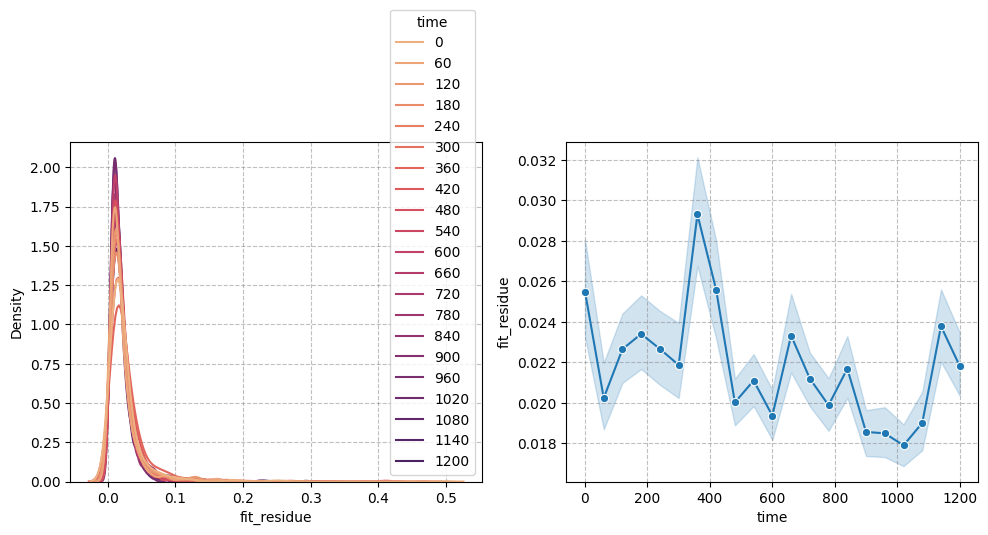

In [33]:
spherical_harmonics_data = results_stress_analysis[0]
df = pd.DataFrame(spherical_harmonics_data[1]['features'])
df['time'] = spherical_harmonics_data[0][:, 0].astype(int) * time_step

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
plotting.draw_chronological_kde_plot(df, x='fit_residue', hue='time', ax=axes[0], colormap=colormap)
plotting.draw_chronological_lineplot_with_errors(df, y='fit_residue', x='time', ax=axes[1],
                                                 error='ci', estimator=np.mean, marker='o', legend=True)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_spherical_harmonics.png'), dpi=300)

### Fit quality

We can quantify the quality of the extracted pointcloud by using the absolute and relative Gauss-Bonnet errors:

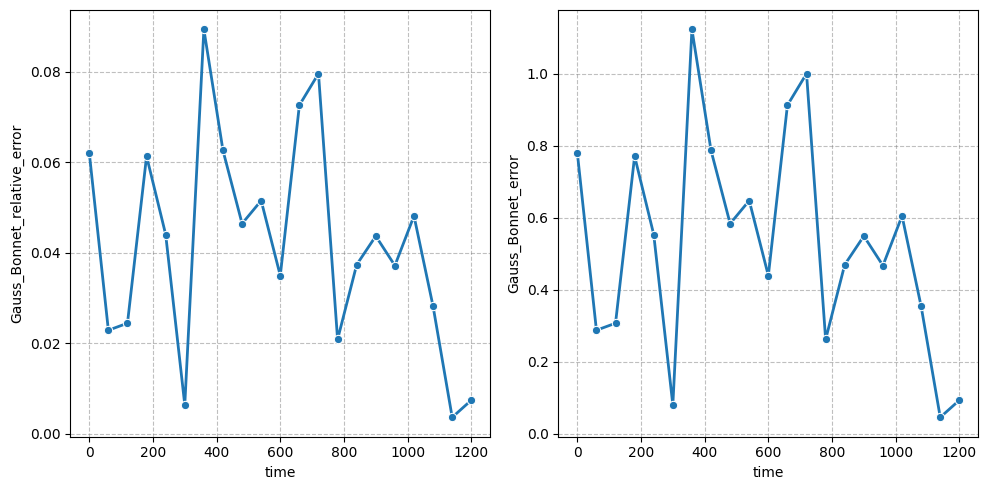

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
plotting.draw_chronological_lineplot_with_errors(df_over_time, y='Gauss_Bonnet_relative_error', ax=axes[0],
                                                    error=None, estimator=None, marker='o', legend=True, linewidth=2)
plotting.draw_chronological_lineplot_with_errors(df_over_time, y='Gauss_Bonnet_error', ax=axes[1],
                                                    error=None, estimator=None, marker='o', legend=True, linewidth=2)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_gauss_bonnet.png'), dpi=300)

## Curvature

We next show mean curvature histograms and averages over time:

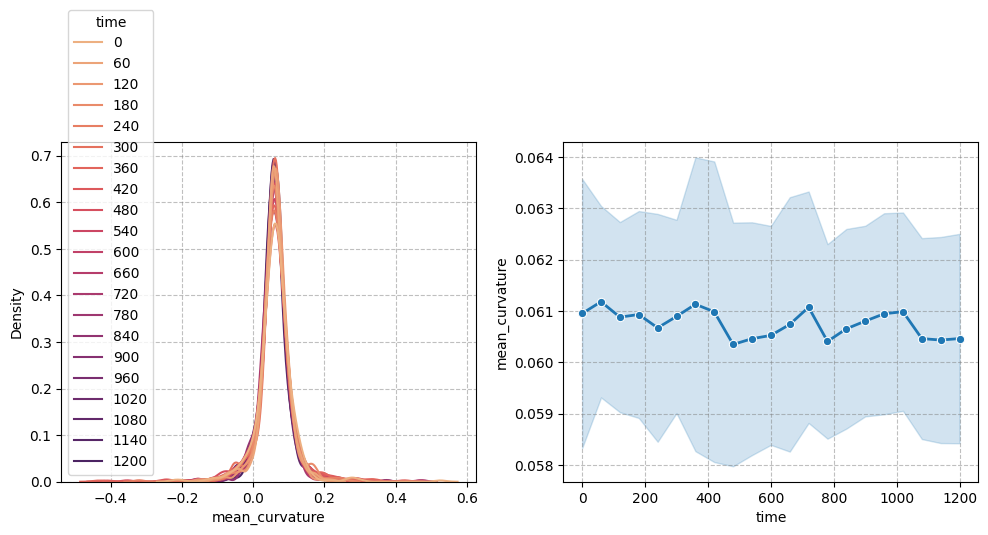

In [35]:
mean_curvature_data = results_stress_analysis[4]
df = pd.DataFrame(mean_curvature_data[1]['features'])
df['time'] = mean_curvature_data[0][:, 0].astype(int) * time_step

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
plotting.draw_chronological_kde_plot(df, x='mean_curvature', hue='time', ax=axes[0], colormap=colormap)
plotting.draw_chronological_lineplot_with_errors(df, y='mean_curvature', x='time', ax=axes[1],
                                                    error='se', estimator=np.mean, marker='o', legend=True, linewidth=2)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'mean_curvature.png'), dpi=300)

### Total stress

In [25]:
total_anisotropic_stress_data = results_stress_analysis[4]
df_total_stress = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df_total_stress['time'] = total_anisotropic_stress_data[0][:, 0] * time_step

total_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df_total_stress[df_total_stress['time']==t*time_step]['anisotropic_stress']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    total_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

df_over_time['total_stress_anisotropy'] = total_stress_anisotropy

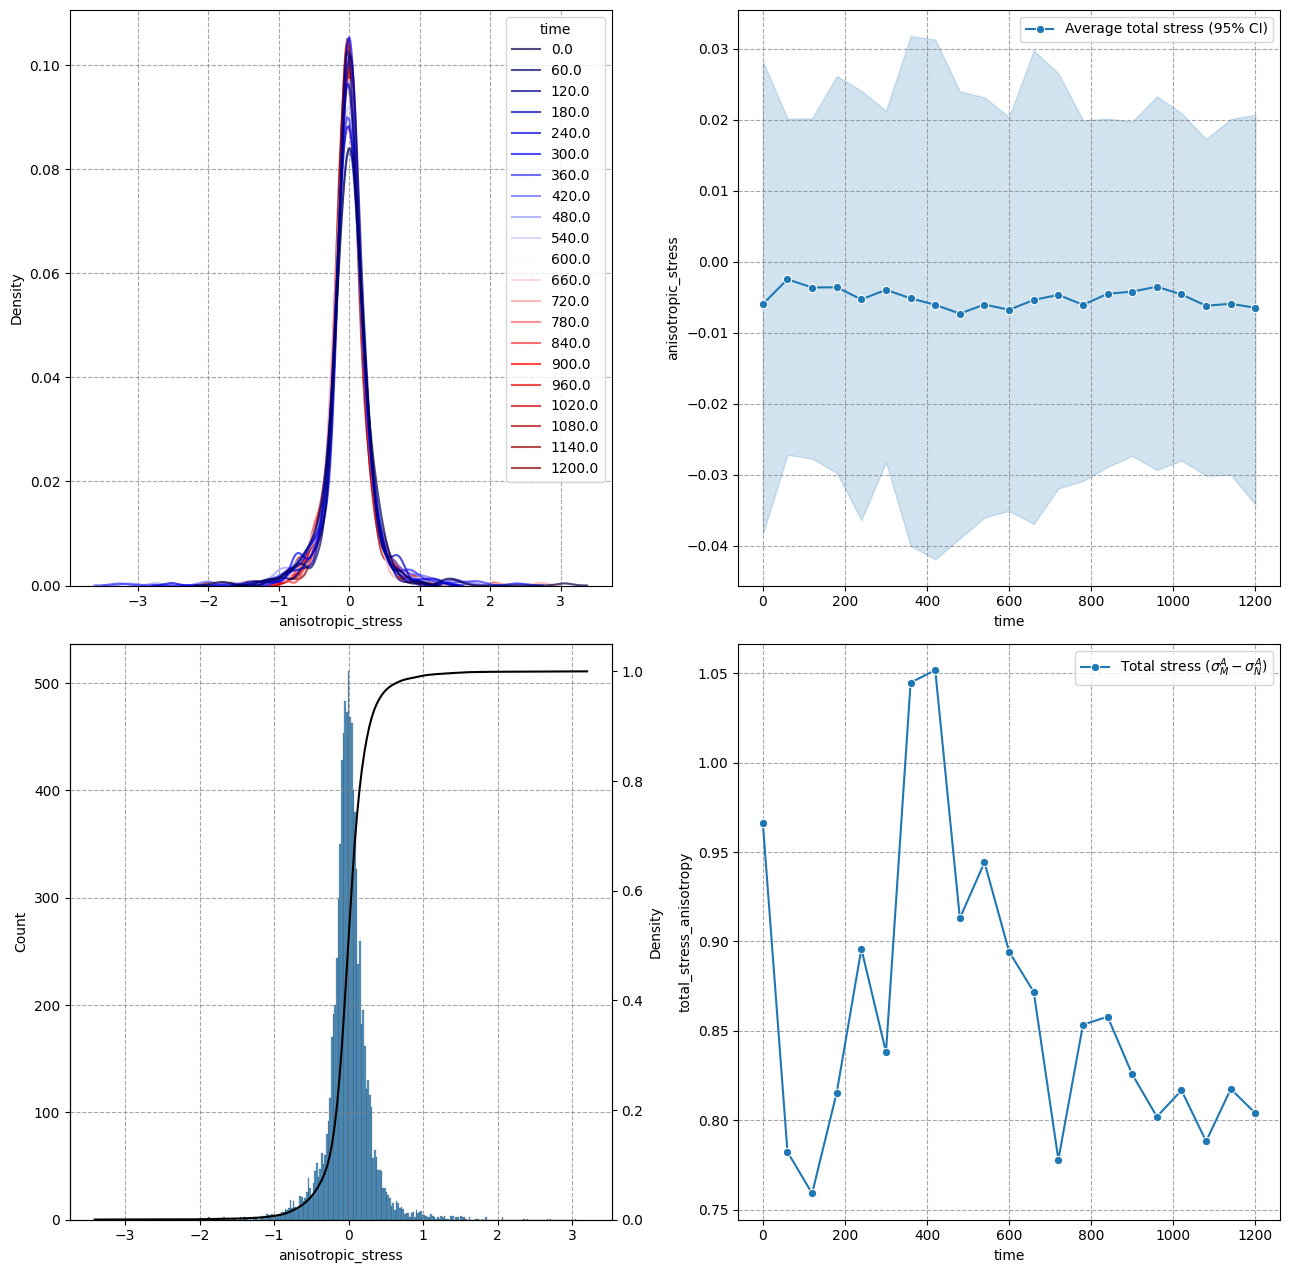

In [26]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
axes = axes.flatten()
_ax2 = axes[2].twinx()
sns.kdeplot(data=df_total_stress, x='anisotropic_stress', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_total_stress, x='time', y='anisotropic_stress', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df_total_stress, x='anisotropic_stress', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df_total_stress, x='anisotropic_stress', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=df_over_time, x='time', y = 'total_stress_anisotropy', label='Total stress ($\sigma^A_M -  \sigma^A_N$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_total.png'), dpi=300)

### Cell-scale stress

In [27]:
alpha=0.05

In [28]:
total_anisotropic_stress_data = results_stress_analysis[4]
df_cell_stress = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df_cell_stress['time'] = total_anisotropic_stress_data[0][:, 0] * time_step

cell_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df_cell_stress[df_cell_stress['time']==t*time_step]['anisotropic_stress_cell']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    cell_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

df_over_time['cell_stress_anisotropy'] = cell_stress_anisotropy

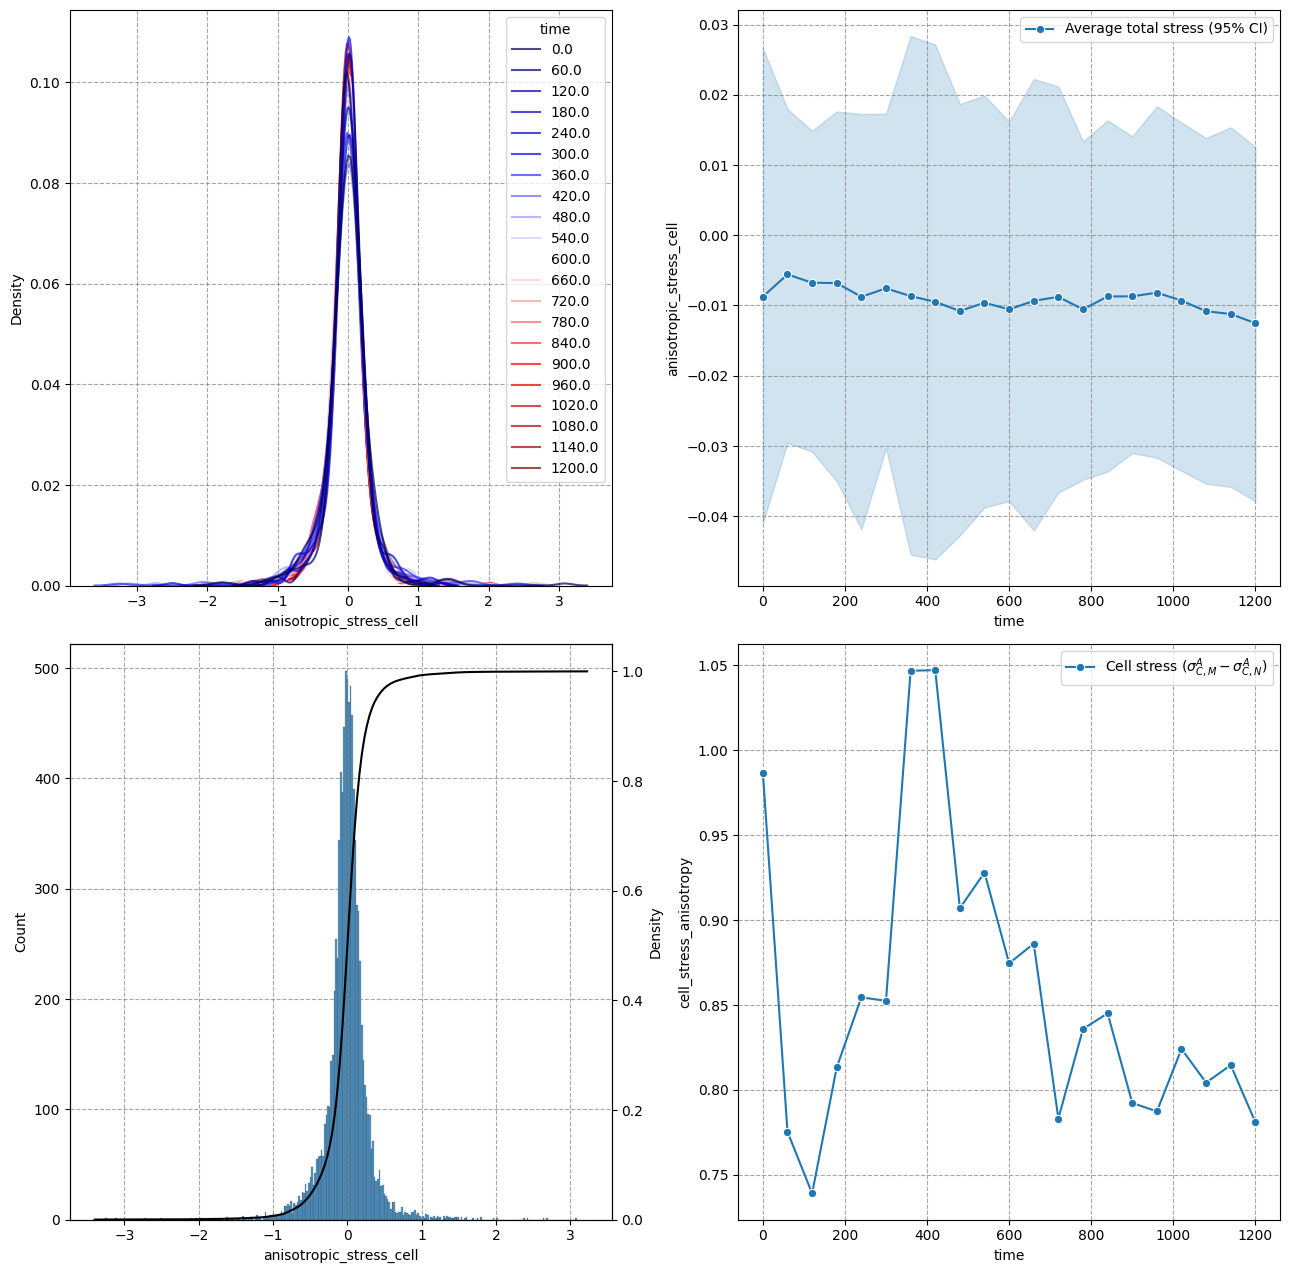

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
axes = axes.flatten()
_ax2 = axes[2].twinx()
sns.kdeplot(data=df_cell_stress, x='anisotropic_stress_cell', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_cell_stress, x='time', y='anisotropic_stress_cell', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df_cell_stress, x='anisotropic_stress_cell', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df_cell_stress, x='anisotropic_stress_cell', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=df_over_time, x='time', y = 'cell_stress_anisotropy', label='Cell stress ($\sigma^A_{C,M} -  \sigma^A_{C,N}$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_cell.png'), dpi=300)

## Tissue-scale stresses

In [30]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
df_tissue_stress = pd.DataFrame(tissue_anisotropic_stress_data[1]['features'])
df_tissue_stress['time'] = total_anisotropic_stress_data[0][:, 0] * time_step
df_over_time['max_tissue_stress_anisotropy'] = tissue_anisotropic_stress_data[1]['metadata']['max_issue_stress_anisotropy']

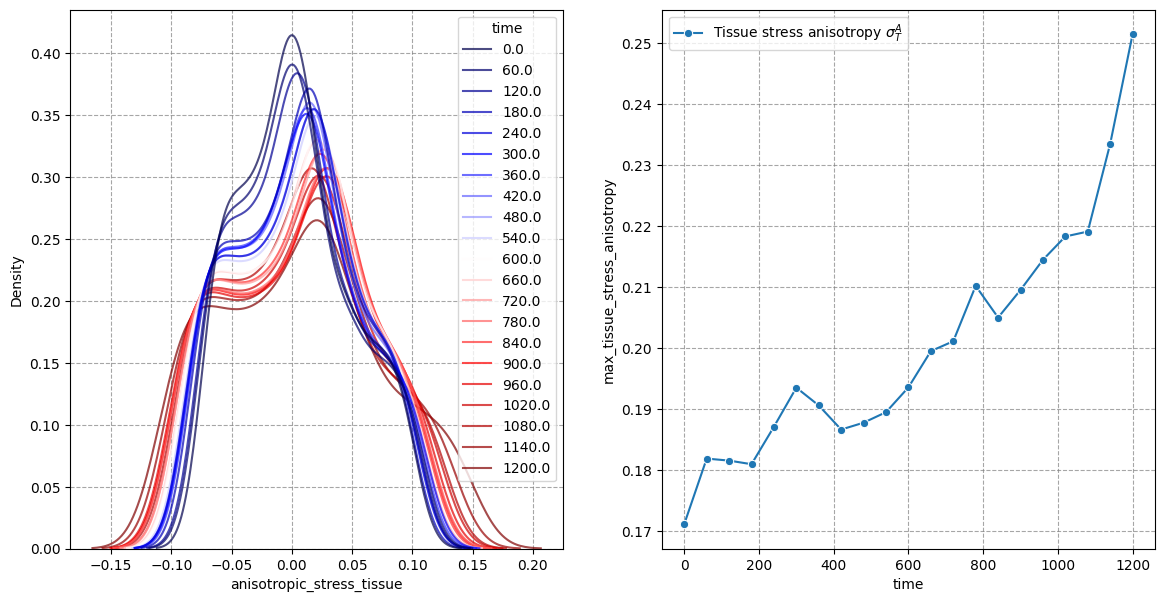

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes = axes.flatten()
sns.kdeplot(data=df_tissue_stress, x='anisotropic_stress_tissue', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_over_time, x='time', y = 'max_tissue_stress_anisotropy',
             label='Tissue stress anisotropy $\sigma^A_T$', marker='o', ax=axes[1])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_tissue.png'), dpi=300)

## Stress along axes

In [32]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
tissue_tensor_elliptical = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_elliptical'])
tissue_tensor_cartesian = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_cartesian'])
df_over_time['stress_along_e1'] = tissue_tensor_elliptical[:, 0, 0]
df_over_time['stress_along_e2'] = tissue_tensor_elliptical[:, 1, 1]
df_over_time['stress_along_e3'] = tissue_tensor_elliptical[:, 2, 2]
df_over_time['stress_anisotropy_e13'] = df_over_time['stress_along_e1'] - df_over_time['stress_along_e3']
df_over_time['stress_anisotropy_e12'] = df_over_time['stress_along_e1'] - df_over_time['stress_along_e2']
df_over_time['stress_anisotropy_e23'] = df_over_time['stress_along_e2'] - df_over_time['stress_along_e3']

In [33]:
angles = np.zeros((n_frames, 3))
for i in range(n_frames):
    _tissue_tensor_elliptical = tissue_tensor_elliptical[i]
    _tissue_tensor_cartesian = tissue_tensor_cartesian[i]
    for j in range(3):
        dot_product = np.dot(_tissue_tensor_cartesian[:, j], _tissue_tensor_elliptical[:, 0])
        norm = np.linalg.norm(_tissue_tensor_cartesian[:, j]) * np.linalg.norm(_tissue_tensor_elliptical[:, 0])
        angles[i, j] = np.arccos(dot_product/norm)*180/np.pi

df_over_time['angle_x1_e1'] = angles[:, 0]
df_over_time['angle_x2_e1'] = angles[:, 1]
df_over_time['angle_x3_e1'] = angles[:, 2]

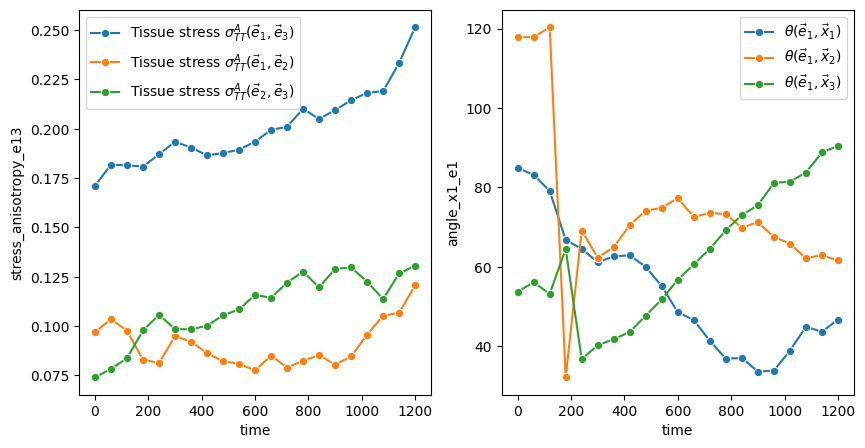

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(data=df_over_time, x='time', y = 'stress_anisotropy_e13', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_3)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y = 'stress_anisotropy_e12', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_2)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y = 'stress_anisotropy_e23', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_2, \\vec{e}_3)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y = 'angle_x1_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_1)$', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='time', y = 'angle_x2_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_2)$', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='time', y = 'angle_x3_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_3)$', marker='o', ax=axes[1])

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_tissue_eigenvectors.png'), dpi=300)

## Geodesics

In [35]:
extrema_cell_stress_data = results_stress_analysis[6]
metadata = extrema_cell_stress_data[1]['metadata']

In [36]:
frames = np.concatenate([[i] * len(metadata['min_max_pair_distances'][i]) for i in range(n_frames)]) * time_step
min_max_pair_distances = np.concatenate(extrema_cell_stress_data[1]['metadata']['min_max_pair_distances'])
min_max_pair_anisotropies = np.concatenate(extrema_cell_stress_data[1]['metadata']['min_max_pair_anisotropies'])
df_all_pairs = pd.DataFrame(np.stack([frames.astype(int), min_max_pair_distances, min_max_pair_anisotropies]).T,
                            columns = ['time', 'min_max_pair_distances', 'min_max_pair_anisotropies'])

In [37]:
frames = np.concatenate([[i] * len(metadata['nearest_min_max_dists'][i]) for i in range(n_frames)]) * time_step
nearest_min_max_distances = np.concatenate(extrema_cell_stress_data[1]['metadata']['nearest_min_max_dists'])
nearest_min_max_anisotropies = np.concatenate(extrema_cell_stress_data[1]['metadata']['nearest_min_max_anisotropies'])
df_nearest_extrema_pairs = pd.DataFrame(np.stack([frames.astype(int), nearest_min_max_distances, nearest_min_max_anisotropies]).T,
                                        columns = ['time', 'nearest_min_max_dists', 'nearest_min_max_anisotropies'])
df_nearest_extrema_pairs = df_nearest_extrema_pairs[df_nearest_extrema_pairs['nearest_min_max_dists'] != 0]

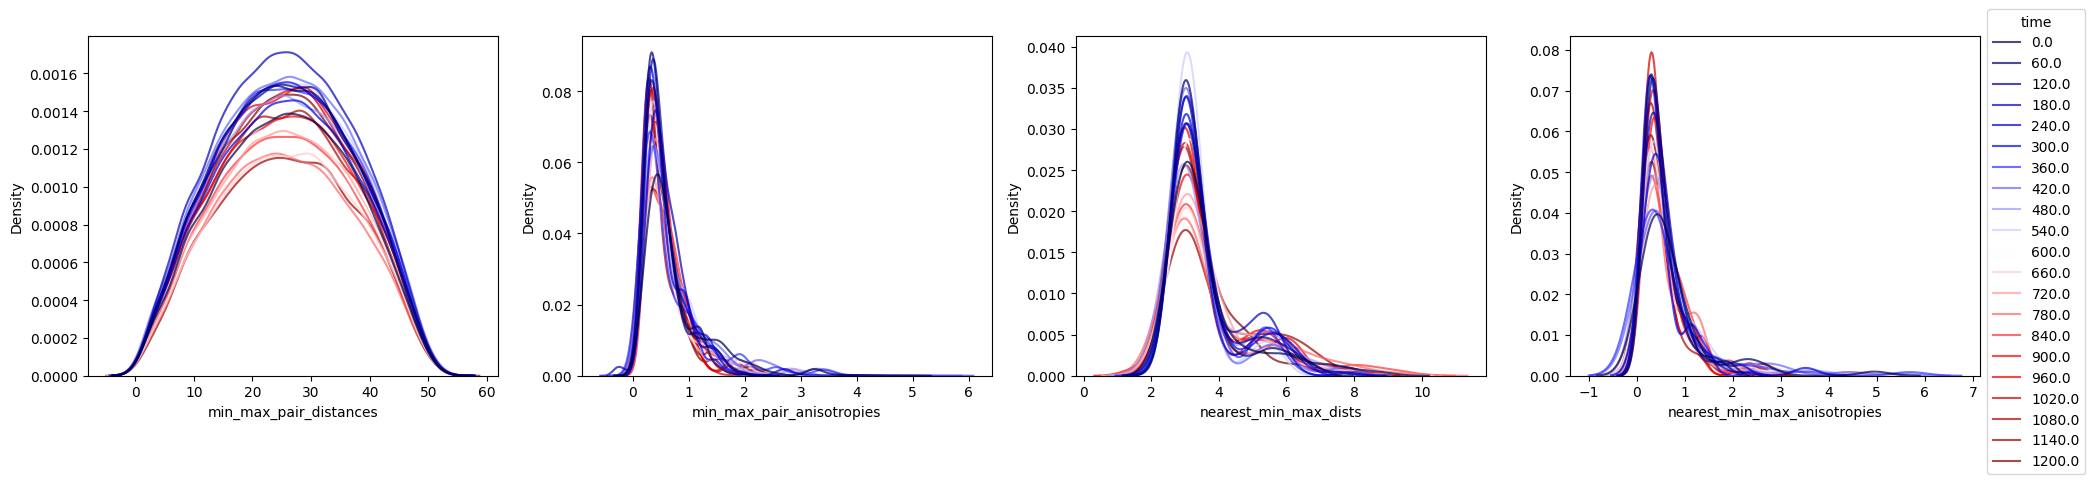

In [38]:
fig, axes = plt.subplots(ncols=4, figsize=(20,5))
sns.kdeplot(data=df_all_pairs, x='min_max_pair_distances', hue='time', ax=axes[0], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_all_pairs, x='min_max_pair_anisotropies', hue='time', ax=axes[1], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_nearest_extrema_pairs, x='nearest_min_max_dists', hue='time', ax=axes[2], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_nearest_extrema_pairs, x='nearest_min_max_anisotropies', hue='time', ax=axes[3], palette=colormap, alpha=0.7)

fig.tight_layout()
leg = axes[-1].get_legend()
leg.set_bbox_to_anchor(bbox=(1, 1.1))

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_nearest_extrema_pairs.png'), dpi=300)

##  Autocorrelations: Spatial

In [39]:
autocorrelations_data = results_stress_analysis[11]
metadata = autocorrelations_data[1]['metadata']

In [40]:
distances = [metadata['autocorrelations_total'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_total = [metadata['autocorrelations_total'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_total'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_total = pd.DataFrame(np.stack([np.concatenate(frames).squeeze() * time_step,
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_total).squeeze(),
                                         ]).T, columns=['time',  'distances', 'autocorrelation_total'])

In [41]:
distances = [metadata['autocorrelations_cell'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_cell = [metadata['autocorrelations_cell'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_cell'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_cell = pd.DataFrame(np.stack([np.concatenate(frames).squeeze() * time_step,
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_cell).squeeze(),
                                         ]).T, columns=['time',  'distances', 'autocorrelation_cell'])

In [42]:
distances = [metadata['autocorrelations_tissue'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_tissue = [metadata['autocorrelations_tissue'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_tissue'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_tissue = pd.DataFrame(np.stack([np.concatenate(frames).squeeze() * time_step,
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_tissue).squeeze()
                                         ]).T, columns=['time',  'distances', 'normalized_autocorrelation_tissue'])

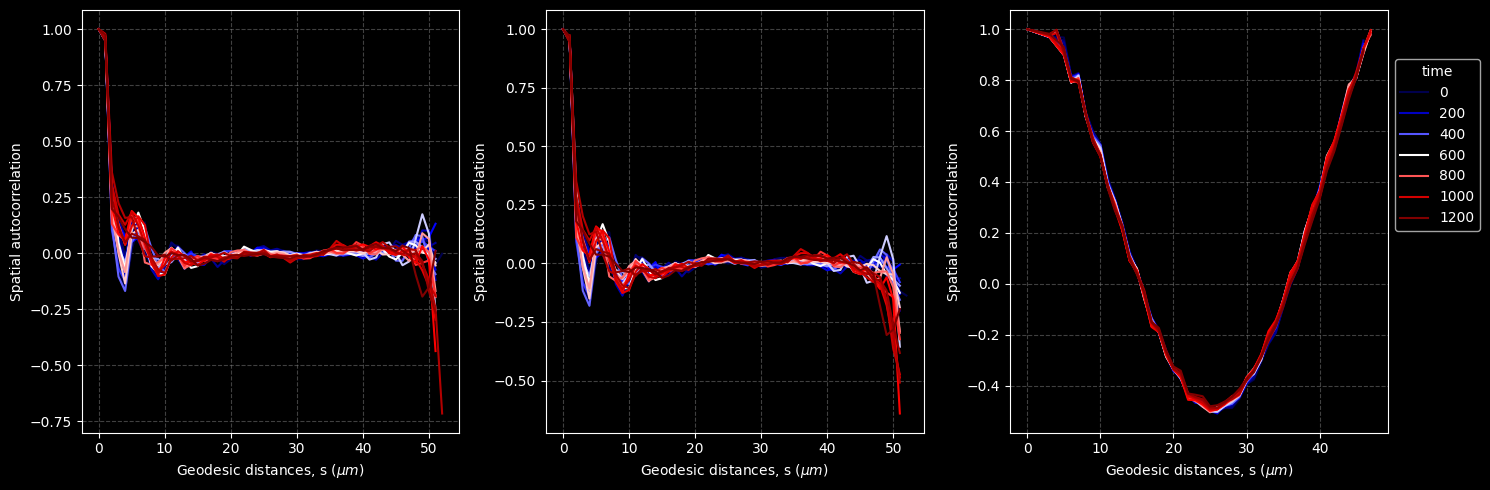

In [43]:
mpl.style.use('dark_background')
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(data=df_autocorrelations_total, x='distances', y='autocorrelation_total', hue='time', palette=colormap, ax=axes[0], legend=False)
sns.lineplot(data=df_autocorrelations_cell, x='distances', y='autocorrelation_cell', hue='time', palette=colormap, ax=axes[1], legend=False)
sns.lineplot(data=df_autocorrelations_tissue, x='distances', y='normalized_autocorrelation_tissue', hue='time', palette=colormap, ax=axes[2])

leg = axes[-1].get_legend()
leg.set_bbox_to_anchor(bbox=(1, 0.9))

for ax in axes:
    ax.set_xlabel('Geodesic distances, s ($\mu m$)')
    ax.set_ylabel('Spatial autocorrelation')
    ax.grid(which='major', linestyle='--', alpha=0.5, color='gray')
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_autocorrelations_spatial.png'), dpi=300)

## Autocorrelations: Temporal

In [44]:
surface_total_stress_radial = list(results_stress_analysis[11][0])
surface_total_stress_radial += [df_total_stress['anisotropic_stress_total_radial'].to_numpy()]

In [45]:
df_over_time['temporal_autocorrelation_stress_total'] = measurements.temporal_autocorrelation(df_total_stress, 'anisotropic_stress_total_radial', frame_column_name='time')
df_over_time['temporal_autocorrelation_stress_cell'] = measurements.temporal_autocorrelation(df_total_stress, 'anisotropic_stress_cell', frame_column_name='time')
df_over_time['temporal_autocorrelation_stress_tissue'] = measurements.temporal_autocorrelation(df_tissue_stress, 'anisotropic_stress_tissue', frame_column_name='time')

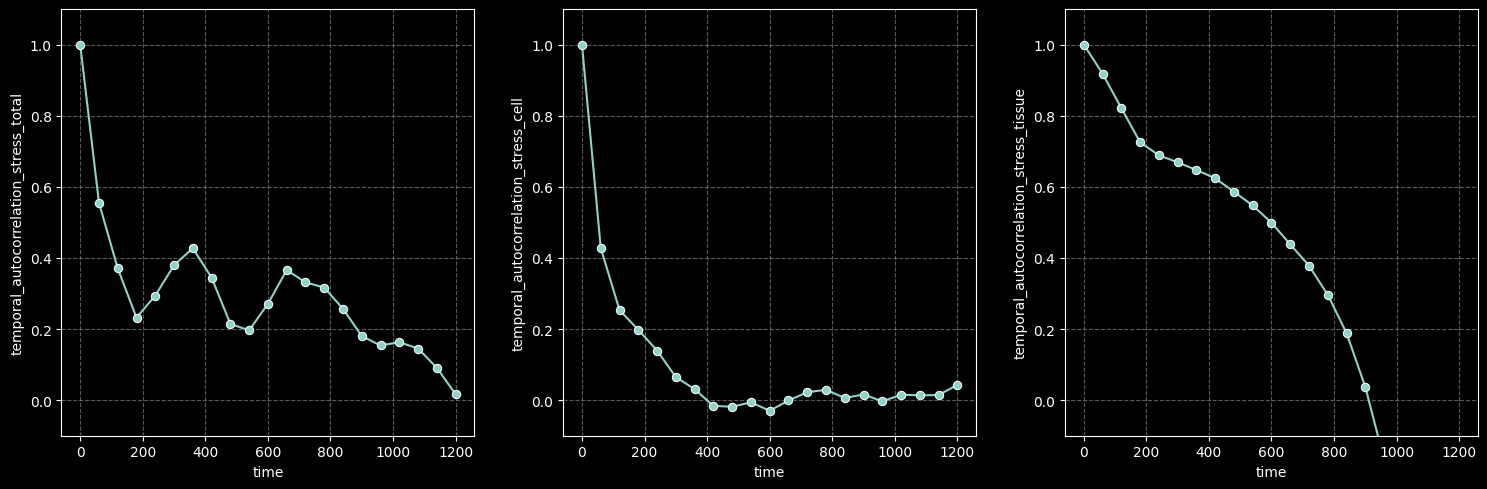

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(data=df_over_time, x='time', y='temporal_autocorrelation_stress_total', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y='temporal_autocorrelation_stress_cell', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='time', y='temporal_autocorrelation_stress_tissue', marker='o', ax=axes[2])
fig.tight_layout()

for ax in axes:
    ax.set_ylim(-0.1, 1.1)
    ax.grid(which='major', color='gray', linestyle='--', alpha=0.7)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_autocorrelations_temporal.png'), dpi=300)

## Ellipsoid deviation

In [47]:
ellipsoid_deviation_data = results_stress_analysis[0]
metadata = ellipsoid_deviation_data[1]['metadata']

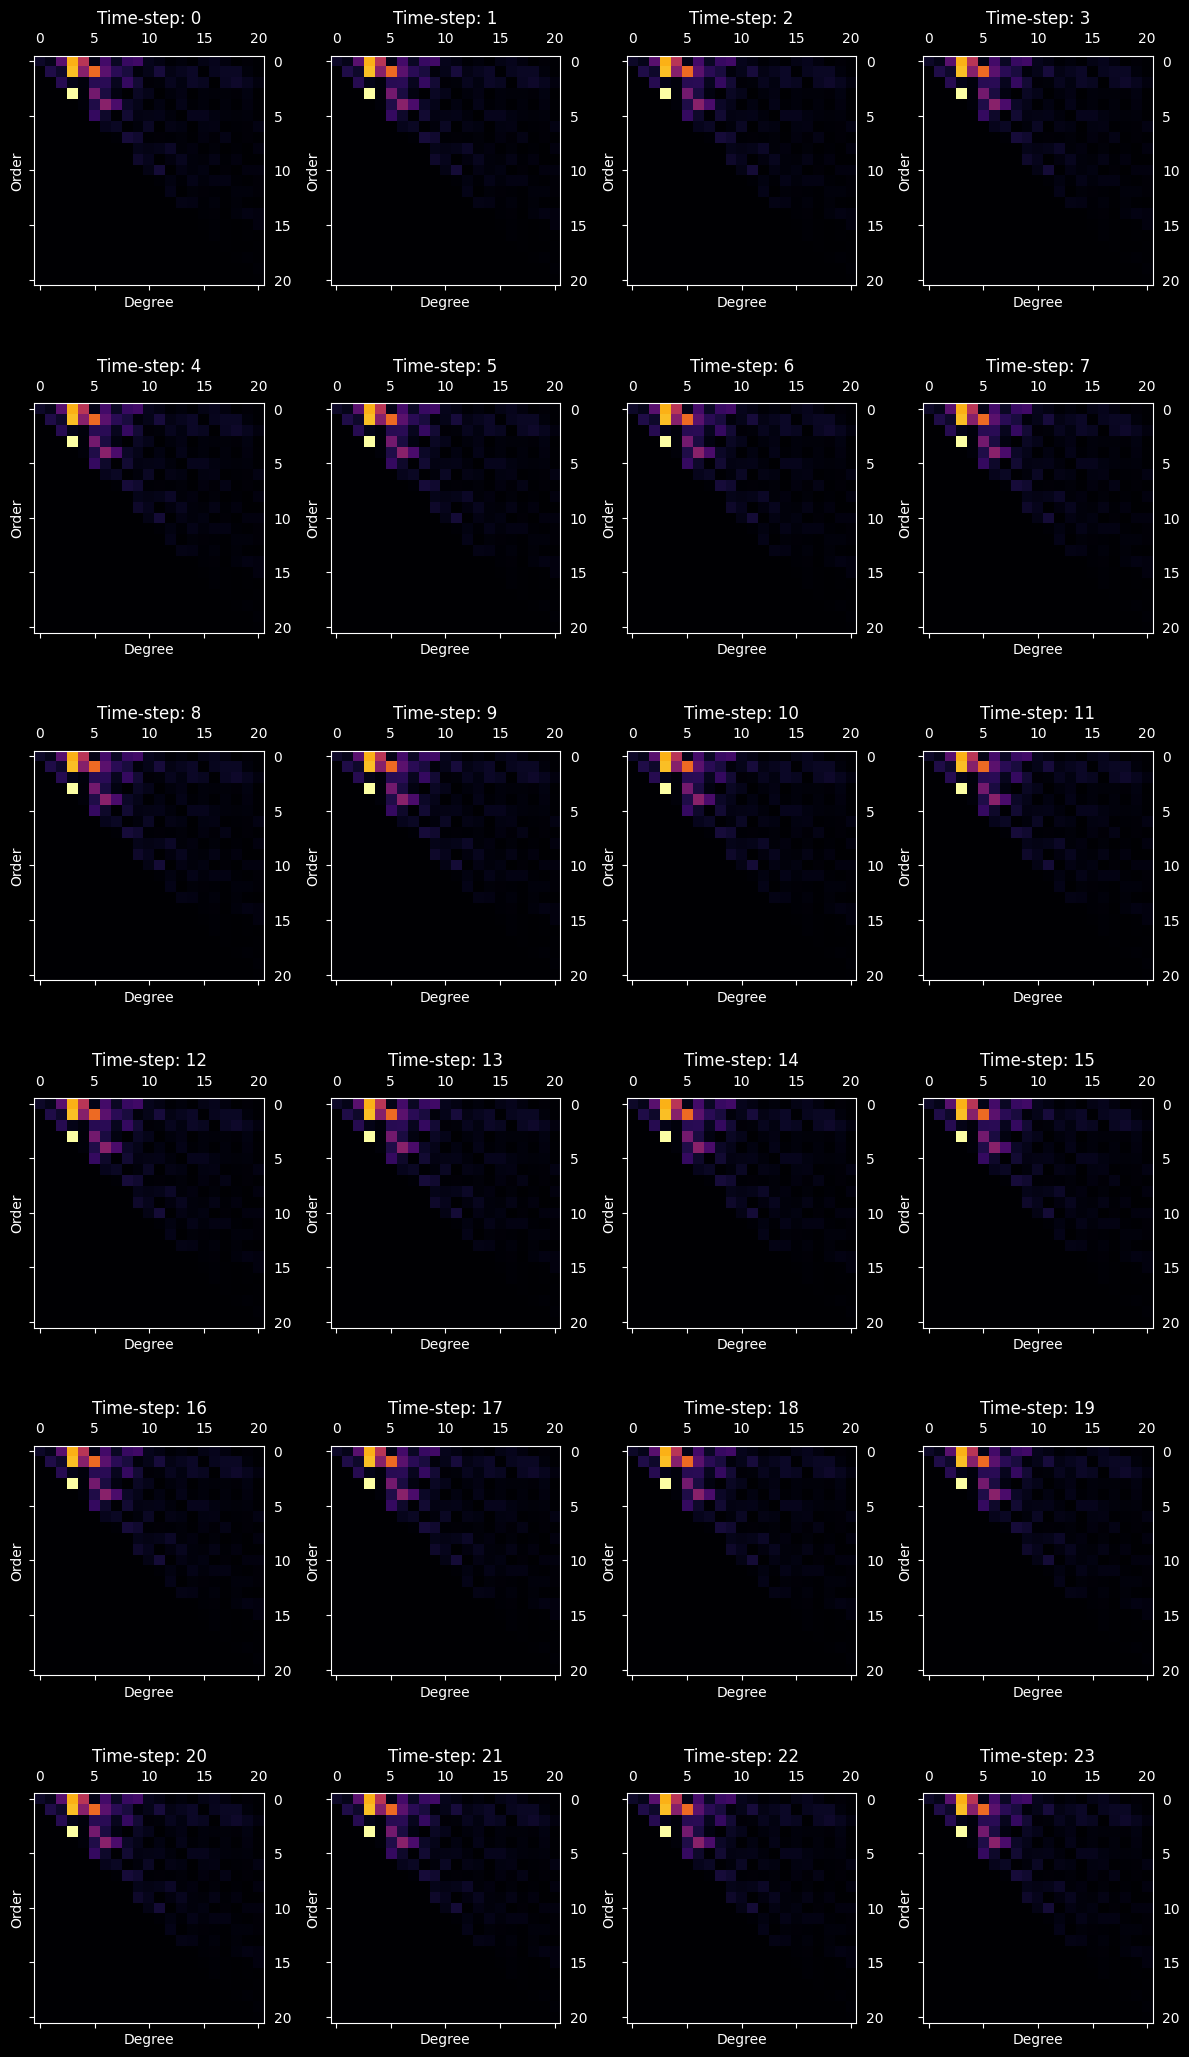

In [48]:
fig, axes = plt.subplots(ncols=4, nrows = n_frames//4 + 1, figsize=(12, n_frames))
for t, ax in enumerate(axes.flatten()):
    ax.imshow(np.triu(metadata['Elipsoid_deviation_contribution_matrix'][0]), cmap='inferno')
    ax.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Order')
    ax.set_title(f'Time-step: {t}')

fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_ellipsoid_deviation_contribution_matrix.png'), dpi=300)

## Droplet movement

This analyzes how much the center of the droplet moves over time.

<Axes: xlabel='time', ylabel='droplet_center_displacement'>

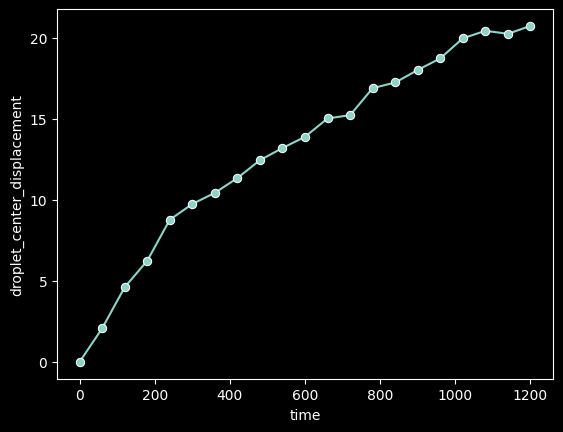

In [49]:
Converter = TimelapseConverter()
list_of_points = Converter.data_to_list_of_data(results_reconstruction[3][0], layertype=napari.types.PointsData)
center = [np.mean(points, axis=0) for points in list_of_points]
center_displacement = np.asarray([np.linalg.norm(center[t] - center[0]) for t in range(n_frames)])
df_over_time['droplet_center_displacement'] =  center_displacement * target_voxel_size

sns.lineplot(data=df_over_time, x='time', y='droplet_center_displacement', marker='o')

## Export data

We first agregate the data from the spatial autocorrelations in a separate dataframe. This dataframe has a column for autocorrelations of total, cell and tissue-scale stresses.

In [50]:
df_autocorrelations = pd.merge(
    df_autocorrelations_total,
    df_autocorrelations_tissue,
    'left',
    on=['time', 'distances'],)
df_autocorrelations = pd.merge(
    df_autocorrelations,
    df_autocorrelations_cell, 
    'left',
    on=['time', 'distances'])

df_autocorrelations.to_csv(os.path.join(save_directory, 'results_autocorrelations.csv'), index=False)

In [51]:
df_to_export = pd.DataFrame()
for col in df_over_time.columns:
    if isinstance(df_over_time[col].iloc[0], np.ndarray):
        continue
    if np.stack(df_over_time[col].to_numpy()).shape == (n_frames,):
        df_to_export[col] = df_over_time[col].to_numpy()

df_to_export.to_csv(os.path.join(save_directory, 'results_over_time.csv'), index=False)

We also export the used settings for the analysis  into a `.yml` file:

In [54]:
utils.export_settings(reconstruction_parameters, file_name=os.path.join(save_directory, 'reconstruction_settings.yaml'))
utils.export_settings(measurement_parameters, file_name=os.path.join(save_directory, 'measurement_settings.yaml'))